# Compute and Analyze Classifier Metrics

The snakemake pipeline output the probability of 0 / 1 for each cell for each classifier. Here, we compute and save many common metrics from these probabilities. Here we analyze the classification results of each allele.

In [1]:
# imports
import os
import polars as pl
import pandas as pd
import numpy as np
from tqdm import tqdm
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    average_precision_score,
    balanced_accuracy_score,
    confusion_matrix,
    f1_score,
    roc_auc_score,
)

## Disable truncation globally
pl.Config.set_tbl_rows(20)  # Show all rows
pl.Config.set_tbl_cols(40)  # Show all columns

## define control types
TC = ["EGFP"]
NC = ["RHEB", "MAPK9", "PRKACB", "SLIRP"]
PC = ["ALK", "ALK_Arg1275Gln", "PTK2B"]
cNC = ["Renilla"]
cPC = ["KRAS", "PTK2B", "GHSR", "ABL1", "BRD4", "OPRM1", "RB1", "ADA", "WT PMP22", "LYN", "TNF", 
       "CYP2A6", "CSK", "PAK1", "ALDH2", "CHRM3", "KCNQ2", "ALK T1151M", "PRKCE", "LPAR1", "PLP1"]
%matplotlib inline

TRN_IMBAL_THRES = 3
MIN_CLASS_NUM = 2

## 1. Metadata

In [2]:
def plot_platemap(df, plate_name, well_pos_col="well_position", gene_allele_col="gene_allele", node_type_col="node_type"):
    # Create a 16x24 grid for the 384-well plate
    rows = list('ABCDEFGHIJKLMNOP')
    cols = [f'{i:02d}' for i in range(1, 25)]
    # Initialize the plate grid with empty values
    plate_grid = pl.DataFrame({col: ['' for _ in rows] for col in cols}, schema={col: pl.Utf8 for col in cols})
    
    # Add a row index to the plate grid
    plate_grid = plate_grid.with_row_index('row')
    # Unpivot the plate grid to long format
    plate_grid = plate_grid.unpivot(index='row', on=cols, variable_name='col', value_name='value')
    
    # Add row and column labels
    plate_grid = plate_grid.with_columns(
        pl.col('row').map_elements(lambda x: rows[x], return_dtype=pl.Utf8).alias('row_label'),  # Map row index to row label (A-P)
        pl.col('col').alias('col_label')  # Use the column name directly as the column label
    )
    # Merge with the input data
    df = df.with_columns(
        pl.col(well_pos_col).str.head(1).alias('row_label'),
        pl.col(well_pos_col).str.slice(1).alias('col_label')
    )
    # Join the input data with the plate grid
    plate_grid = plate_grid.join(df, on=['row_label', 'col_label'], how='left')
    # Fill missing values in the gene column
    plate_grid = plate_grid.with_columns(
        pl.col(gene_allele_col).fill_null(''),
        pl.col(gene_allele_col).str.replace("_", '\n')
        .alias('label')
    )
    # Reshape the grid for plotting
    # heatmap_data = plate_grid.pivot(index='row_label', columns='col_label', values='color').fill_null('white')
    heatmap_data = plate_grid.pivot(index='row_label', on='col_label', values='label').fill_null('')
    # print(heatmap_data)
    # Assign colors based on conditions
    heatmap_colors = plate_grid.pivot(index='row_label', on='col_label', values=node_type_col).fill_null('')
    # print(heatmap_colors)

    # Convert to numpy arrays for plotting
    heatmap_labels = heatmap_data[:, 1:].to_numpy()
    heatmap_colors = heatmap_colors[:, 1:].to_numpy()
    # print(heatmap_colors)
    
    # Create a color map for the heatmap
    color_map = {
        '_TC_': 'slategrey', # Grey for controls
        'TC': 'slategrey', # Grey for controls
        'NC': 'gainsboro', 
        'PC': 'plum',
        'cPC': 'pink',
        'cNC': 'lightgrey',
        'allele': 'salmon',  # Tomato for disease
        'disease_wt': 'lightskyblue',  # Skyblue for reference
        '': 'white'  # White for missing wells
    }
    
    # Map the colors to the grid
    heatmap_colors = np.vectorize(color_map.get)(heatmap_colors)
    
    # Plot the heatmap
    plt.figure(figsize=(35, 13.5))
    sns.heatmap(
        np.zeros_like(heatmap_labels, dtype=int),  # Dummy data for heatmap
        annot=heatmap_labels,
        fmt='',
        # cmap='viridis',  # Dummy colormap (not used for coloring)
        cbar=False,
        linewidths=1,
        linecolor='black',
        square=True,
        annot_kws={'size': 8.5, 'color': 'black'}
    )
    
    # Apply colors manually
    for i in range(heatmap_colors.shape[0]):
        for j in range(heatmap_colors.shape[1]):
            plt.gca().add_patch(plt.Rectangle((j, i), 1, 1, color=heatmap_colors[i, j], fill=True))
    
    # Customize the plot
    plt.title(f"384-Well Plate Map: {plate_name}", fontsize=16)
    plt.xlabel('Columns', fontsize=12)
    plt.ylabel('Rows', fontsize=12)
    plt.xticks(ticks=np.arange(1,25)-.5, labels=cols, rotation=0)
    plt.yticks(ticks=np.arange(16) + 0.5, labels=rows, rotation=0)
    
    # Show the plot
    plt.tight_layout()
    plt.show()
    
    return plate_grid

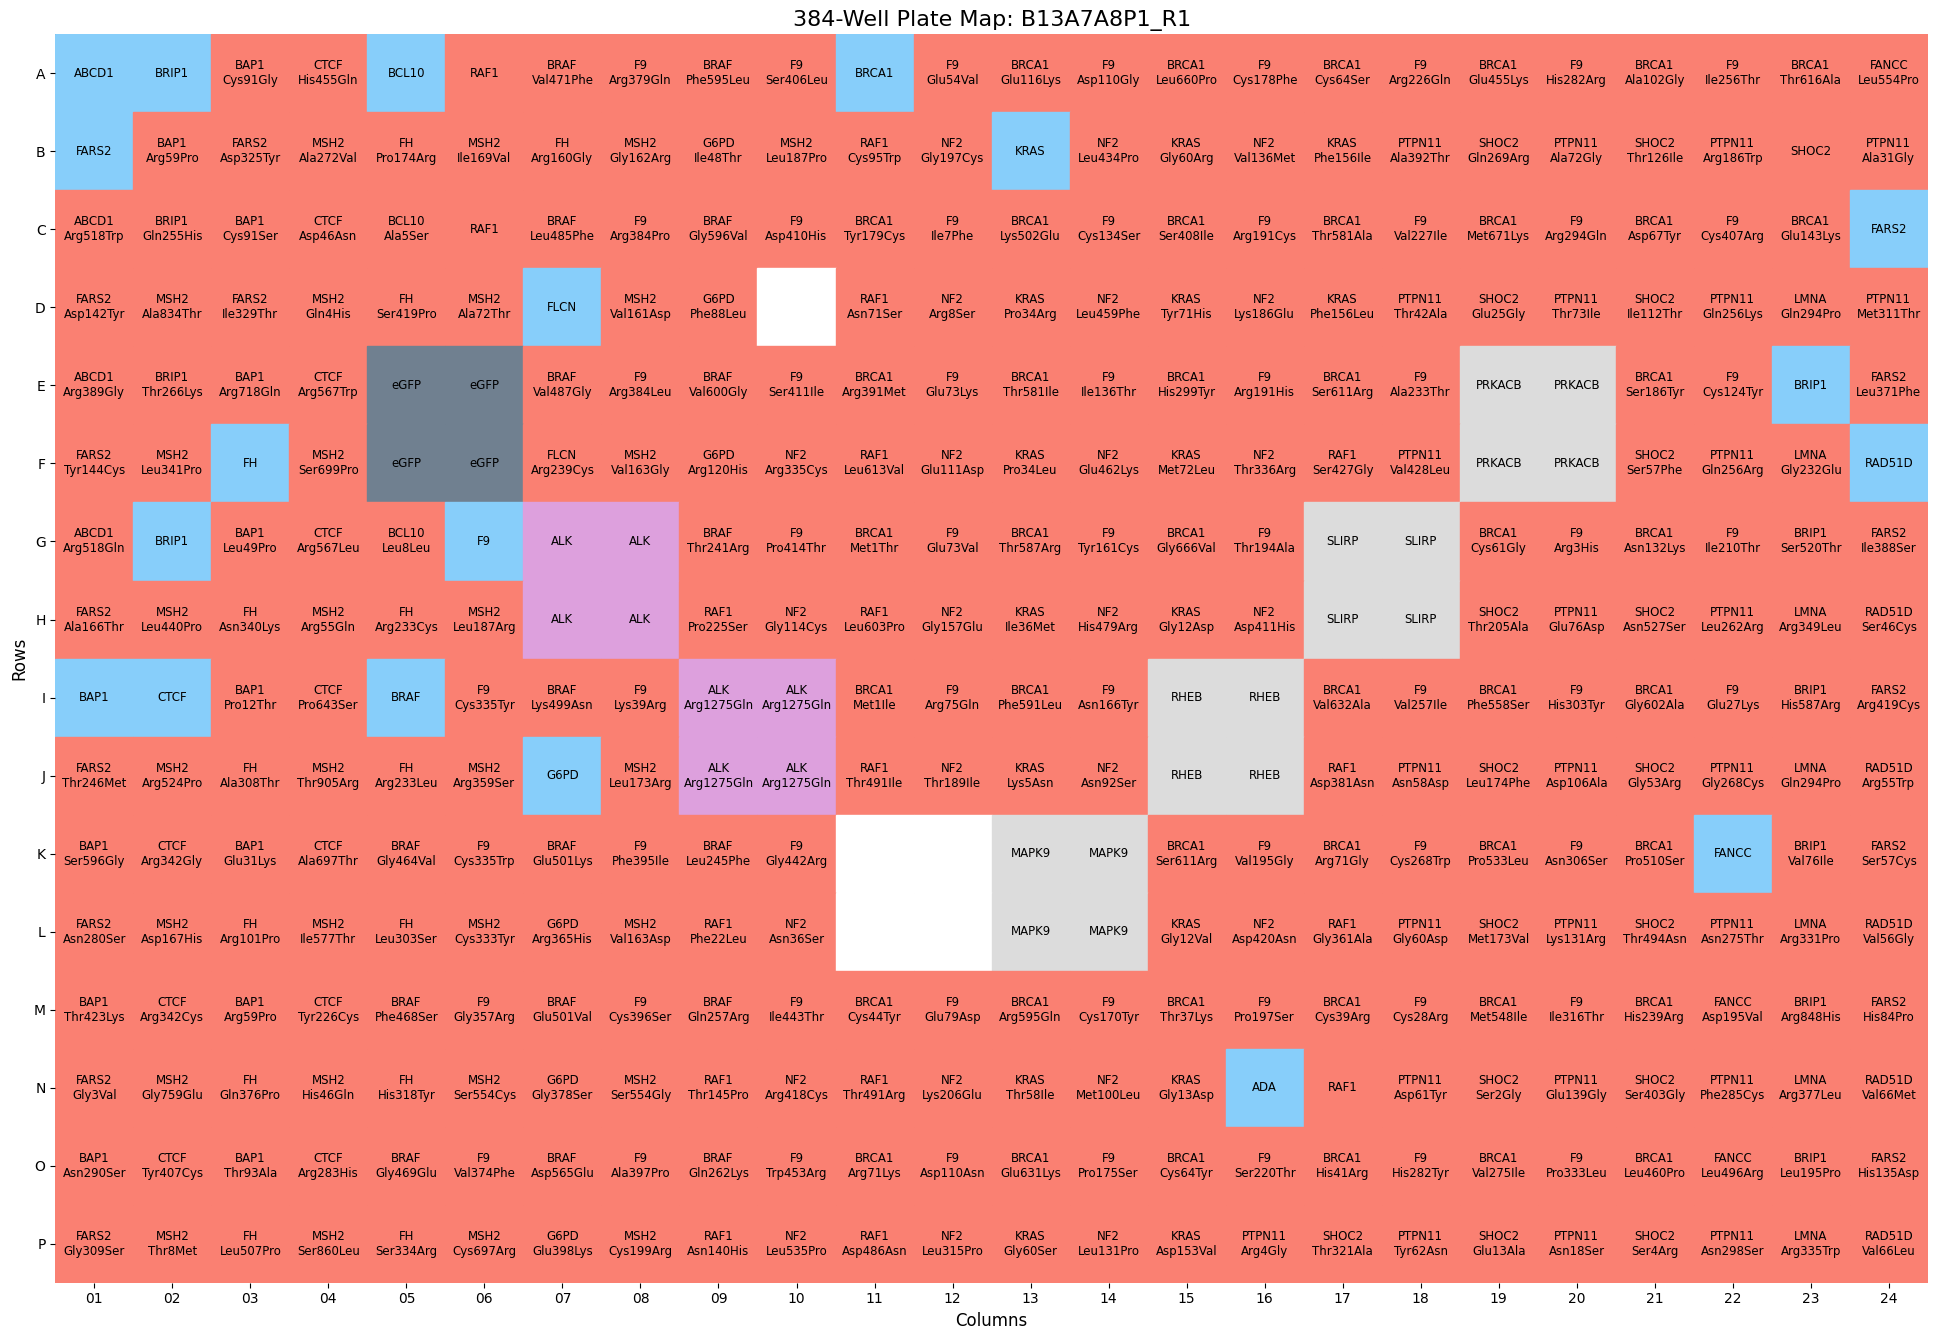

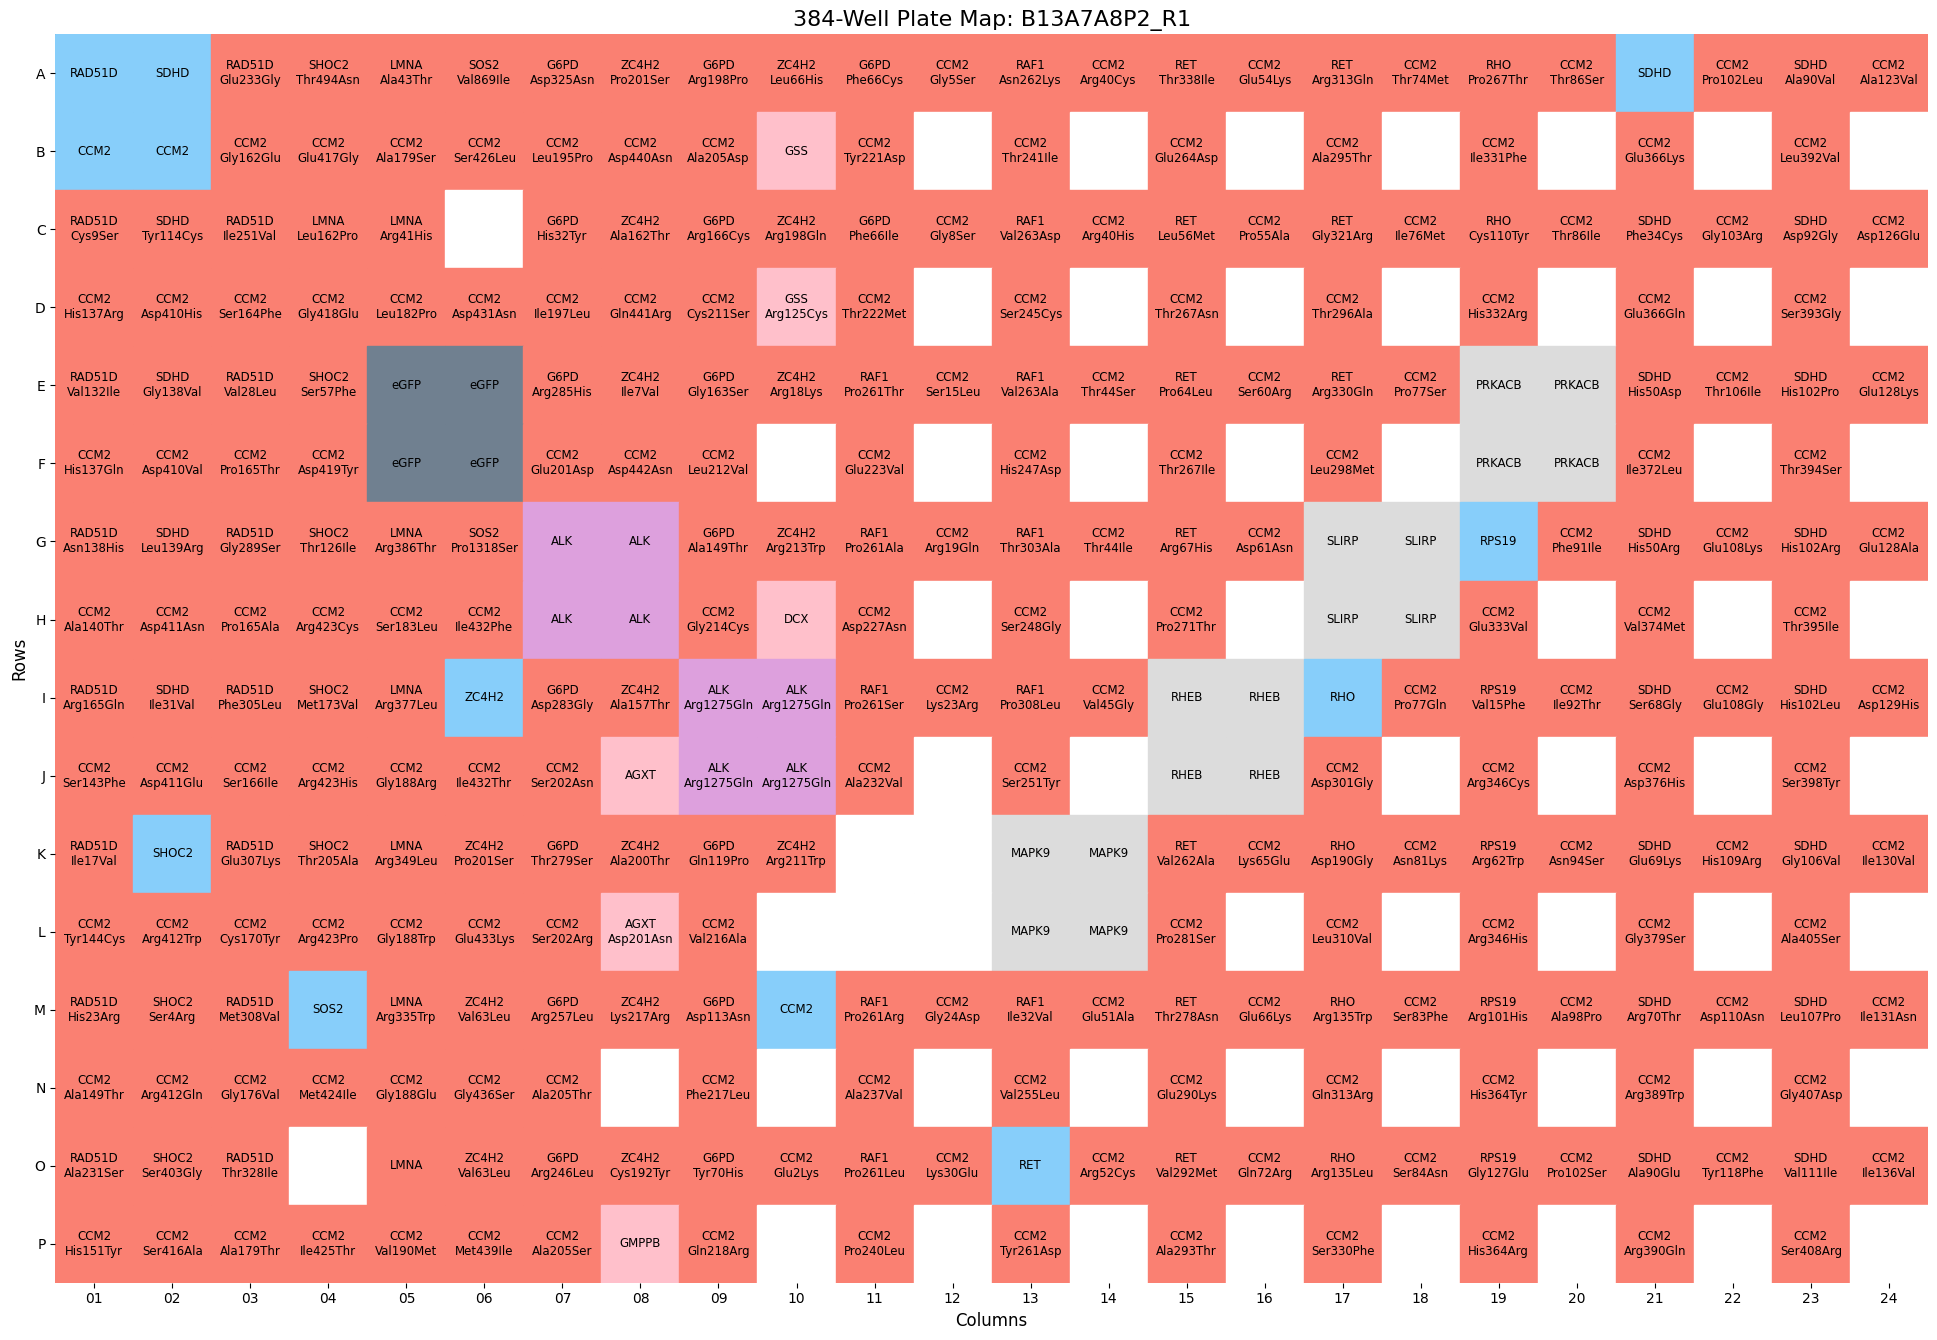

In [7]:
batch_id = "2025_01_27_Batch_13"
platemap_dir = f"../../../8.2_updated_snakemake_pipeline/inputs/metadata/platemaps/{batch_id}/platemap"
for platemap in os.listdir(platemap_dir):
    platemap_df = pl.read_csv(os.path.join(platemap_dir, platemap), separator="\t")
    plate_grid = plot_platemap(platemap_df, plate_name=platemap.split('.')[0])

## 2. Classification metrics

### 2.1 Analyze the metrics per each classifier:

Each tested allele should have 2 (protein mislocalization & morphology) * 4 (technical replicates) = 8 classifiers per each batch.

In [ ]:
metrics_df = pl.read_csv("../../../8.2_updated_snakemake_pipeline/outputs/classification_analyses/2025_01_27_Batch_13/profiles_tcdropped_filtered_var_mad_outlier_featselect_filtcells/metrics.csv")
metrics_df.filter(pl.col("allele_0")=="BRCA1_Met1Thr")

AUROC,AUPRC,AUBPRC,Macro_F1,Sensitivity,Specificity,Balanced_Accuracy,Classifier_ID,Full_Classifier_ID,Plate,trainsize_0,testsize_0,well_0,allele_0,trainsize_1,testsize_1,well_1,allele_1,Metadata_Control,train_prob_1,test_prob_1,Training_imbalance,Testing_imbalance
f64,f64,f64,f64,f64,f64,f64,str,str,str,i64,i64,str,str,i64,i64,str,str,bool,f64,f64,f64,f64
0.762847,0.572374,0.817586,0.666111,0.668571,0.740614,0.704593,"""2025_01_27_B13A7A8P1_T1_G11_A1…","""2025_01_27_B13A7A8P1_T1_G11_A1…","""2025_01_27_B13A7A8P1_T1""",2240,586,"""G11""","""BRCA1_Met1Thr""",1360,175,"""A11""","""BRCA1""",false,0.377778,0.229961,1.647059,3.348571
0.965533,0.953534,0.968302,0.903333,0.849315,0.947853,0.898584,"""2025_01_27_B13A7A8P1_T3_G11_A1…","""2025_01_27_B13A7A8P1_T3_G11_A1…","""2025_01_27_B13A7A8P1_T3""",2174,652,"""G11""","""BRCA1_Met1Thr""",1097,438,"""A11""","""BRCA1""",false,0.335371,0.401835,1.981768,1.488584
0.841112,0.675963,0.874771,0.540125,0.954286,0.423208,0.688747,"""2025_01_27_B13A7A8P1_T1_G11_A1…","""2025_01_27_B13A7A8P1_T1_G11_A1…","""2025_01_27_B13A7A8P1_T1""",2240,586,"""G11""","""BRCA1_Met1Thr""",1360,175,"""A11""","""BRCA1""",false,0.377778,0.229961,1.647059,3.348571
0.979652,0.97014,0.97666,0.928541,0.933544,0.92629,0.929917,"""2025_01_27_B13A7A8P1_T4_G11_A1…","""2025_01_27_B13A7A8P1_T4_G11_A1…","""2025_01_27_B13A7A8P1_T4""",2419,407,"""G11""","""BRCA1_Met1Thr""",1219,316,"""A11""","""BRCA1""",false,0.335074,0.437068,1.984413,1.287975
0.733269,0.698224,0.774986,0.681827,0.586758,0.773006,0.679882,"""2025_01_27_B13A7A8P1_T3_G11_A1…","""2025_01_27_B13A7A8P1_T3_G11_A1…","""2025_01_27_B13A7A8P1_T3""",2174,652,"""G11""","""BRCA1_Met1Thr""",1097,438,"""A11""","""BRCA1""",false,0.335371,0.401835,1.981768,1.488584
0.704631,0.697369,0.74798,0.659429,0.547468,0.769042,0.658255,"""2025_01_27_B13A7A8P1_T4_G11_A1…","""2025_01_27_B13A7A8P1_T4_G11_A1…","""2025_01_27_B13A7A8P1_T4""",2419,407,"""G11""","""BRCA1_Met1Thr""",1219,316,"""A11""","""BRCA1""",false,0.335074,0.437068,1.984413,1.287975
0.710094,0.606651,0.750352,0.667426,0.493399,0.829805,0.661602,"""2025_01_27_B13A7A8P1_T2_G11_A1…","""2025_01_27_B13A7A8P1_T2_G11_A1…","""2025_01_27_B13A7A8P1_T2""",1645,1181,"""G11""","""BRCA1_Met1Thr""",929,606,"""A11""","""BRCA1""",false,0.360917,0.339116,1.770721,1.948845
0.88896,0.760264,0.86073,0.583291,0.219472,0.974598,0.597035,"""2025_01_27_B13A7A8P1_T2_G11_A1…","""2025_01_27_B13A7A8P1_T2_G11_A1…","""2025_01_27_B13A7A8P1_T2""",1645,1181,"""G11""","""BRCA1_Met1Thr""",929,606,"""A11""","""BRCA1""",false,0.360917,0.339116,1.770721,1.948845


In [ ]:
metrics_df.filter(pl.col("allele_1")=="CCM2")
metrics_df.filter(pl.col("allele_0")=="CCM2_Arg390Gln")

AUROC,AUPRC,AUBPRC,Macro_F1,Sensitivity,Specificity,Balanced_Accuracy,Classifier_ID,Full_Classifier_ID,Plate,trainsize_0,testsize_0,well_0,allele_0,trainsize_1,testsize_1,well_1,allele_1,Metadata_Control,train_prob_1,test_prob_1,Training_imbalance,Testing_imbalance
f64,f64,f64,f64,f64,f64,f64,str,str,str,i64,i64,str,str,i64,i64,str,str,bool,f64,f64,f64,f64
0.804524,0.961816,0.818877,0.625903,0.836428,0.458128,0.647278,"""2025_01_27_B13A7A8P2_T1_P21_M1…","""2025_01_27_B13A7A8P2_T1_P21_M1…","""2025_01_27_B13A7A8P2_T1""",776,203,"""P21""","""CCM2_Arg390Gln""",3691,1131,"""M10""","""CCM2""",false,0.826282,0.847826,4.756443,5.571429
0.729709,0.899331,0.715291,0.631671,0.855172,0.400545,0.627859,"""2025_01_27_B13A7A8P2_T4_P21_M1…","""2025_01_27_B13A7A8P2_T4_P21_M1…","""2025_01_27_B13A7A8P2_T4""",612,367,"""P21""","""CCM2_Arg390Gln""",3517,1305,"""M10""","""CCM2""",false,0.85178,0.780502,5.746732,3.555858
0.891388,0.966011,0.888801,0.754767,0.941762,0.520436,0.731099,"""2025_01_27_B13A7A8P2_T4_P21_M1…","""2025_01_27_B13A7A8P2_T4_P21_M1…","""2025_01_27_B13A7A8P2_T4""",612,367,"""P21""","""CCM2_Arg390Gln""",3517,1305,"""M10""","""CCM2""",false,0.85178,0.780502,5.746732,3.555858
0.823337,0.968456,0.838431,0.609352,0.890924,0.325123,0.608024,"""2025_01_27_B13A7A8P2_T3_P21_M1…","""2025_01_27_B13A7A8P2_T3_P21_M1…","""2025_01_27_B13A7A8P2_T3""",776,203,"""P21""","""CCM2_Arg390Gln""",3621,1201,"""M10""","""CCM2""",false,0.823516,0.855413,4.666237,5.916256
0.737084,0.934709,0.713359,0.62085,0.898734,0.334951,0.616843,"""2025_01_27_B13A7A8P2_T2_P21_B0…","""2025_01_27_B13A7A8P2_T2_P21_B0…","""2025_01_27_B13A7A8P2_T2""",773,206,"""P21""","""CCM2_Arg390Gln""",3637,1185,"""B02""","""CCM2""",false,0.824717,0.851905,4.705045,5.752427
0.813181,0.956512,0.788031,0.691251,0.875104,0.55665,0.715877,"""2025_01_27_B13A7A8P2_T3_P21_M1…","""2025_01_27_B13A7A8P2_T3_P21_M1…","""2025_01_27_B13A7A8P2_T3""",776,203,"""P21""","""CCM2_Arg390Gln""",3621,1201,"""M10""","""CCM2""",false,0.823516,0.855413,4.666237,5.916256
0.808922,0.96315,0.819614,0.616249,0.884388,0.349515,0.616951,"""2025_01_27_B13A7A8P2_T2_P21_B0…","""2025_01_27_B13A7A8P2_T2_P21_B0…","""2025_01_27_B13A7A8P2_T2""",773,206,"""P21""","""CCM2_Arg390Gln""",3637,1185,"""B02""","""CCM2""",false,0.824717,0.851905,4.705045,5.752427
0.772543,0.943718,0.750596,0.671617,0.856764,0.536946,0.696855,"""2025_01_27_B13A7A8P2_T1_P21_M1…","""2025_01_27_B13A7A8P2_T1_P21_M1…","""2025_01_27_B13A7A8P2_T1""",776,203,"""P21""","""CCM2_Arg390Gln""",3691,1131,"""M10""","""CCM2""",false,0.826282,0.847826,4.756443,5.571429


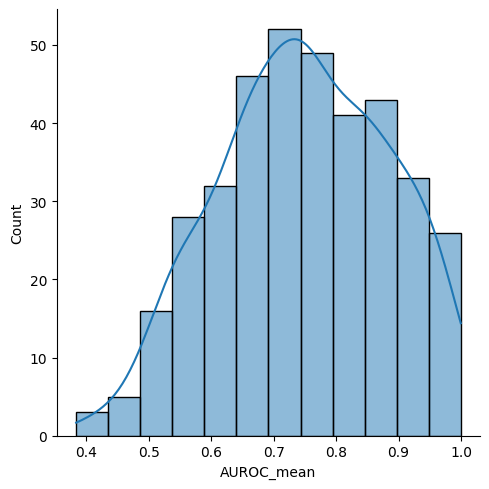

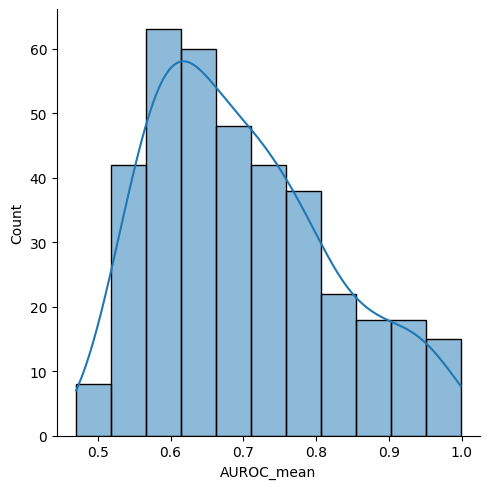

In [14]:
metrics_sum_df = pl.read_csv("../../../8.2_updated_snakemake_pipeline/outputs/classification_analyses/2025_01_27_Batch_13/profiles_tcdropped_filtered_var_mad_outlier_featselect_filtcells/metrics_summary.csv")
metrics_sum_df

for classifier in ["morphology", "localization"]:
    sns.displot(data=metrics_sum_df.filter(pl.col("Classifier_type")==classifier), x="AUROC_mean", kde=True)

In [6]:
metrics_files = [
    "../../../8.2_updated_snakemake_pipeline/outputs/classification_analyses/2025_01_27_Batch_13/profiles_tcdropped_filtered_var_mad_outlier_featselect_filtcells/metrics.csv",
    "../../../8.2_updated_snakemake_pipeline/outputs/classification_analyses/2025_01_28_Batch_14/profiles_tcdropped_filtered_var_mad_outlier_featselect_filtcells/metrics.csv"
]
metric_df_dict = {}

for metric_file in metrics_files:
    metrics_df = pl.read_csv(metric_file)

    batch_id = [subdir for subdir in metric_file.split("/") if "Batch" in subdir][0]
    batch_id = f"B{batch_id.split('Batch_')[-1]}"

    # print(metrics_df)
    # metrics_df = metrics_df.filter((~pl.col("Plate").str.contains("B13"))&(~pl.col("Plate").str.contains("B14")))

    metrics_df = metrics_df.with_columns(
        pl.when(pl.col("Metadata_Control"))
        .then(pl.lit("1_Ctrl"))
        .otherwise(pl.lit("2_VAR-WT"))
        .alias("Node_Type"),
        pl.when(pl.col("Full_Classifier_ID").str.contains("true"))
        .then(pl.lit("localization"))
        .otherwise(pl.lit("morphology"))
        .alias("Classifier_type"),
        # Extract the substring that:
        #  1. Has a digit (\d) immediately before it (anchors the match at a number)
        #  2. Starts with 'A' and then as few characters as needed (A.*?), captured as group 1
        #  3. Stops right before the literal 'T'
        pl.col("Plate").str.extract(r"\d(A.*?)T", 1).alias("Allele_set"),
        pl.col("Full_Classifier_ID").str.split("_").list.last().alias("Batch")
    )
    # Filter based on class imbalance
    metrics_ctrl = (
        metrics_df.filter(
            (pl.col("Training_imbalance") < TRN_IMBAL_THRES) & (pl.col("Metadata_Control"))
        )
        .select(["Classifier_type", "Batch", "AUROC"])
        .group_by(["Classifier_type", "Batch"])
        .agg([
            pl.col("AUROC").quantile(0.99).alias("AUROC_thresh"),
            pl.col("AUROC").mean().alias("AUROC_mean"),
            pl.col("AUROC").std().alias("AUROC_std")
        ])
    )
    # print(metrics_ctrl)

    metric_df_dict[f"{batch_id}_met"] = metrics_df

    # Merge with metrics_df and decide whether it passed the threshold
    metrics_df_thres = metrics_df.join(metrics_ctrl, on=["Classifier_type", "Batch"])
    # print(metrics_df_thres.head())

    metrics_df_thres = metrics_df_thres.with_columns(
        ((pl.col("AUROC") - pl.col("AUROC_mean")) / pl.col("AUROC_std")).alias("AUROC_zscore")
    )

    # Must be at least min_class_num classifiers per batch
    # Number of classifiers is the same for localization and morph, so just use morph
    classifier_count = (
        metrics_df_thres.filter(
            (~pl.col("Metadata_Control"))
            & (pl.col("Classifier_type") == "localization")
        )
        .group_by(["allele_0", "Allele_set", "Batch", "allele_1"])
        .agg([pl.len().alias("Number_classifiers")])
    )
    classifier_count = classifier_count.pivot(
        index=["allele_0", "allele_1", "Allele_set"],
        on="Batch",
        values="Number_classifiers",
    )
    print("Total number of unique classifiers:", classifier_count.shape[0])
    print("Total number of unique variant alleles:", len(classifier_count.select("allele_0").to_series().unique().to_list()))
    print("Total number of unique WT genes:", len(classifier_count.select("allele_1").to_series().unique().to_list()))
    print("==========================================================================")

    # Must be at least min_class_num classifiers per batch
    # Number of classifiers is the same for localization and morph, so just use morph
    classifier_count = (
        metrics_df_thres.filter(
            (pl.col("Training_imbalance") < TRN_IMBAL_THRES)
            & (~pl.col("Metadata_Control"))
            & (pl.col("Classifier_type") == "localization")
        )
        .group_by(["allele_0", "Allele_set", "Batch", "allele_1"])
        .agg([pl.len().alias("Number_classifiers")])
    )
    classifier_count = classifier_count.pivot(
        index=["allele_0", "allele_1", "Allele_set"],
        on="Batch",
        values="Number_classifiers",
    )
    print("After filtering out classifiers with training imbalance > 3:")
    print("Total number of unique classifiers:", classifier_count.shape)
    print("Total number of unique variant alleles:", len(classifier_count.select("allele_0").to_series().unique().to_list()))
    print("Total number of unique WT genes:", len(classifier_count.select("allele_1").to_series().unique().to_list()))
    print("==========================================================================")

    classifier_count = classifier_count.filter(
        (pl.col(batch_id) >= MIN_CLASS_NUM)
    )
    print("After filtering out alleles with available number of classifiers < 2:")
    print("Total number of unique classifiers:", classifier_count.shape)
    print("Total number of unique variant alleles:", len(classifier_count.select("allele_0").to_series().unique().to_list()))
    print("Total number of unique WT genes:", len(classifier_count.select("allele_1").to_series().unique().to_list()))

    # filter based on this
    keep_alleles = classifier_count.select("allele_0").to_series().unique().to_list()
    metrics_df_thres = metrics_df_thres.filter(
        ~((~pl.col("Metadata_Control")) & ~pl.col("allele_0").is_in(keep_alleles))
    )

    # Filter by imbalance and calculate mean AUROC for each batch
    metrics_wtvar = (
        (
            metrics_df_thres.filter(
                (pl.col("Training_imbalance") < TRN_IMBAL_THRES) & (~pl.col("Metadata_Control"))
            )
        )
        .select([
            "AUROC",
            "AUROC_zscore",
            "Classifier_type",
            "Batch",
            "AUROC_thresh",
            "allele_0",
            "trainsize_0",
            "testsize_0",
            "trainsize_1",
            "testsize_1",
            "Allele_set",
            "Training_imbalance",
        ])
        .group_by(["Classifier_type", "allele_0", "Allele_set", "Batch", "AUROC_thresh"])
        .agg([
            pl.all()
            .exclude(["Classifier_type", "allele_0", "Allele_set", "Batch", "AUROC_thresh"])
            .mean()
            .name.suffix("_mean")
        ])
    )

    metric_df_dict[f"{batch_id}_met_thres"] = metrics_df_thres
    metric_df_dict[f"{batch_id}_allele_summary"] = metrics_wtvar

Total number of unique classifiers: 461
Total number of unique variant alleles: 459
Total number of unique WT genes: 26
After filtering out classifiers with training imbalance > 3:
Total number of unique classifiers: (402, 4)
Total number of unique variant alleles: 400
Total number of unique WT genes: 25
After filtering out alleles with available number of classifiers < 2:
Total number of unique classifiers: (374, 4)
Total number of unique variant alleles: 372
Total number of unique WT genes: 25
Total number of unique classifiers: 459
Total number of unique variant alleles: 457
Total number of unique WT genes: 26
After filtering out classifiers with training imbalance > 3:
Total number of unique classifiers: (417, 4)
Total number of unique variant alleles: 415
Total number of unique WT genes: 25
After filtering out alleles with available number of classifiers < 2:
Total number of unique classifiers: (385, 4)
Total number of unique variant alleles: 383
Total number of unique WT genes: 2

In [7]:
metric_df_dict[f"B13_met_thres"]

AUROC,AUPRC,AUBPRC,Macro_F1,Sensitivity,Specificity,Balanced_Accuracy,Classifier_ID,Full_Classifier_ID,Plate,trainsize_0,testsize_0,well_0,allele_0,trainsize_1,testsize_1,well_1,allele_1,Metadata_Control,train_prob_1,test_prob_1,Training_imbalance,Testing_imbalance,Node_Type,Classifier_type,Allele_set,Batch,AUROC_thresh,AUROC_mean,AUROC_std,AUROC_zscore
f64,f64,f64,f64,f64,f64,f64,str,str,str,i64,i64,str,str,i64,i64,str,str,bool,f64,f64,f64,f64,str,str,str,str,f64,f64,f64,f64
0.762847,0.572374,0.817586,0.666111,0.668571,0.740614,0.704593,"""2025_01_27_B13A7A8P1_T1_G11_A1…","""2025_01_27_B13A7A8P1_T1_G11_A1…","""2025_01_27_B13A7A8P1_T1""",2240,586,"""G11""","""BRCA1_Met1Thr""",1360,175,"""A11""","""BRCA1""",false,0.377778,0.229961,1.647059,3.348571,"""2_VAR-WT""","""localization""","""A7A8P1_""","""B13""",0.918113,0.588914,0.118899,1.462858
0.643772,0.800694,0.604391,0.605442,0.830986,0.37037,0.600678,"""2025_01_27_B13A7A8P1_T1_O09_I0…","""2025_01_27_B13A7A8P1_T1_O09_I0…","""2025_01_27_B13A7A8P1_T1""",474,162,"""O09""","""BRAF_Gln262Lys""",1333,426,"""I05""","""BRAF""",false,0.737687,0.72449,2.812236,2.62963,"""2_VAR-WT""","""localization""","""A7A8P1_""","""B13""",0.918113,0.588914,0.118899,0.461379
0.694484,0.695284,0.62808,0.580557,0.960452,0.259542,0.609997,"""2025_01_27_B13A7A8P1_T2_O18_G0…","""2025_01_27_B13A7A8P1_T2_O18_G0…","""2025_01_27_B13A7A8P1_T2""",431,131,"""O18""","""F9_His282Tyr""",797,177,"""G06""","""F9""",false,0.649023,0.574675,1.849188,1.351145,"""2_VAR-WT""","""localization""","""A7A8P1_""","""B13""",0.918113,0.588914,0.118899,0.88789
0.361273,0.228609,0.434687,0.399938,0.387387,0.44184,0.414614,"""2025_01_27_B13A7A8P1_T3_K14_K1…","""2025_01_27_B13A7A8P1_T3_K14_K1…","""2025_01_27_B13A7A8P1_T3""",2687,1152,"""K14""","""MAPK9""",2501,444,"""K13""","""MAPK9""",true,0.482074,0.278195,1.07437,2.594595,"""1_Ctrl""","""morphology""","""A7A8P1_""","""B13""",0.930661,0.57966,0.16601,-1.315503
0.663698,0.796582,0.641295,0.605332,0.795781,0.408503,0.602142,"""2025_01_27_B13A7A8P2_T2_J01_B0…","""2025_01_27_B13A7A8P2_T2_J01_B0…","""2025_01_27_B13A7A8P2_T2""",1604,541,"""J01""","""CCM2_Ser143Phe""",3637,1185,"""B02""","""CCM2""",false,0.693952,0.686559,2.267456,2.190388,"""2_VAR-WT""","""localization""","""A7A8P2_""","""B13""",0.918113,0.588914,0.118899,0.628967
0.647322,0.618962,0.641325,0.591034,0.538462,0.643927,0.591194,"""2025_01_27_B13A7A8P2_T1_O23_A0…","""2025_01_27_B13A7A8P2_T1_O23_A0…","""2025_01_27_B13A7A8P2_T1""",1619,601,"""O23""","""SDHD_Val111Ile""",1766,546,"""A02""","""SDHD""",false,0.521713,0.476024,1.090797,1.100733,"""2_VAR-WT""","""localization""","""A7A8P2_""","""B13""",0.918113,0.588914,0.118899,0.491232
0.58655,0.664333,0.580669,0.535565,0.719472,0.358491,0.538981,"""2025_01_27_B13A7A8P2_T2_E02_A2…","""2025_01_27_B13A7A8P2_T2_E02_A2…","""2025_01_27_B13A7A8P2_T2""",1289,424,"""E02""","""SDHD_Gly138Val""",1706,606,"""A21""","""SDHD""",false,0.569616,0.58835,1.323507,1.429245,"""2_VAR-WT""","""morphology""","""A7A8P2_""","""B13""",0.930661,0.57966,0.16601,0.041501
0.767612,0.840125,0.724323,0.675234,0.701835,0.678899,0.690367,"""2025_01_27_B13A7A8P1_T3_M10_G0…","""2025_01_27_B13A7A8P1_T3_M10_G0…","""2025_01_27_B13A7A8P1_T3""",445,109,"""M10""","""F9_Ile443Thr""",756,218,"""G06""","""F9""",false,0.629475,0.666667,1.698876,2.0,"""2_VAR-WT""","""morphology""","""A7A8P1_""","""B13""",0.930661,0.57966,0.16601,1.13217
0.916847,0.878976,0.883327,0.842443,0.953535,0.738372,0.845954,"""2025_01_27_B13A7A8P2_T3_G04_K0…","""2025_01_27_B13A7A8P2_T3_G04_K0…","""2025_01_27_B13A7A8P2_T3""",897,516,"""G04""","""SHOC2_Thr126Ile""",1833,495,"""K02""","""SHOC2""",false,0.671429,0.489614,2.043478,1.042424,"""2_VAR-WT""","""localization""","""A7A8P2_""","""B13""",0.918113,0.588914,0.118899,2.758066


In [8]:
metric_df_dict[f"B13_allele_summary"]

Classifier_type,allele_0,Allele_set,Batch,AUROC_thresh,AUROC_mean,AUROC_zscore_mean,trainsize_0_mean,testsize_0_mean,trainsize_1_mean,testsize_1_mean,Training_imbalance_mean
str,str,str,str,f64,f64,f64,f64,f64,f64,f64,f64
"""morphology""","""LMNA_Arg377Leu""","""A7A8P2_""","""B13""",0.930661,0.732651,0.921574,1392.75,464.25,1422.75,474.25,1.054121
"""localization""","""CCM2_Ile197Leu""","""A7A8P2_""","""B13""",0.918113,0.569068,-0.16692,1299.75,433.25,3616.5,1205.5,2.786179
"""localization""","""F9_Gly357Arg""","""A7A8P1_""","""B13""",0.918113,0.520415,-0.576117,535.5,178.5,730.5,243.5,1.372833
"""morphology""","""CCM2_Thr44Ile""","""A7A8P2_""","""B13""",0.930661,0.741669,0.975896,1260.666667,343.333333,3615.0,1207.0,2.86848
"""localization""","""CCM2_Lys65Glu""","""A7A8P2_""","""B13""",0.918113,0.622421,0.281809,1302.5,350.5,3577.0,1245.0,2.746818
"""localization""","""F9_Ser406Leu""","""A7A8P1_""","""B13""",0.918113,0.801962,1.791829,302.0,73.0,722.0,252.0,2.393365
"""localization""","""BAP1_Asn290Ser""","""A7A8P1_""","""B13""",0.918113,0.470191,-0.99852,1279.5,426.5,1183.5,394.5,1.104157
"""localization""","""CCM2_Ala140Thr""","""A7A8P2_""","""B13""",0.918113,0.750907,1.362438,1986.75,662.25,3616.5,1205.5,1.821021
"""morphology""","""CCM2_Ser164Phe""","""A7A8P2_""","""B13""",0.930661,0.980616,2.415244,1494.0,498.0,3616.5,1205.5,2.441122


## 3. Plotting Metrics

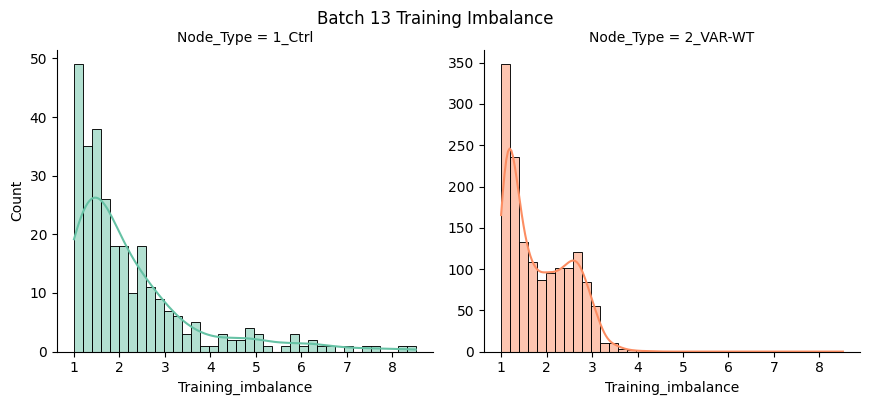

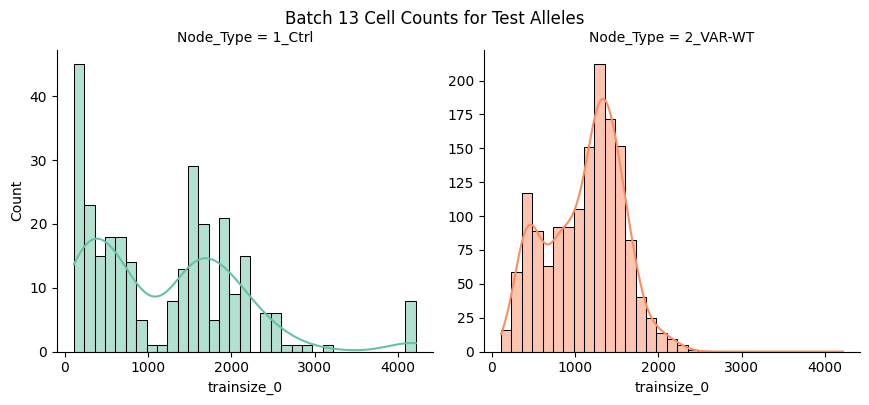

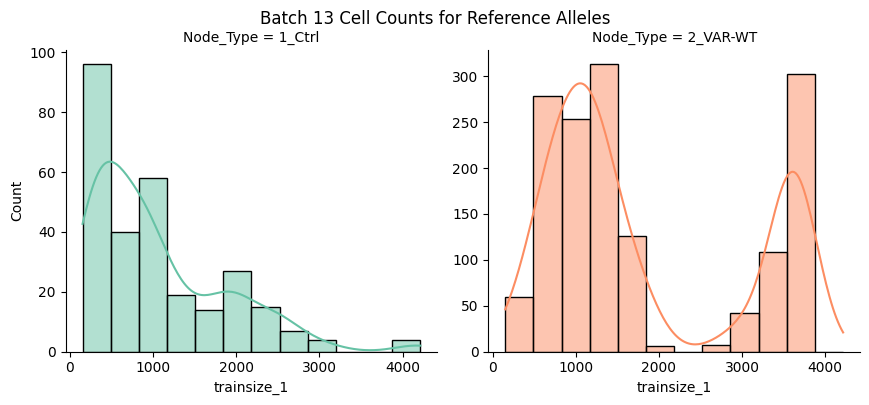

In [9]:
# Plot with vertical lines
g = sns.displot(
    data=metric_df_dict["B13_met_thres"].filter(pl.col("Classifier_type") == "localization"), 
    x="Training_imbalance", col="Node_Type", kde=True,
    facet_kws={'sharey': False, 'col_order': sorted(metrics_df['Node_Type'].unique())},
    hue="Node_Type", palette="Set2", hue_order=sorted(metrics_df['Node_Type'].unique()),
    legend=False, height=4, aspect=1.1
)

g.fig.suptitle("Batch 13 Training Imbalance", fontsize=12, y=1.)
g.fig.subplots_adjust(top=0.9)

# Plot with vertical lines
g = sns.displot(
    data=metric_df_dict["B13_met_thres"].filter(pl.col("Classifier_type") == "localization"), 
    x="trainsize_0", col="Node_Type", kde=True,
    facet_kws={'sharey': False, 'col_order': sorted(metrics_df['Node_Type'].unique())},
    hue="Node_Type", palette="Set2", hue_order=sorted(metrics_df['Node_Type'].unique()),
    legend=False, height=4, aspect=1.1
)

g.fig.suptitle("Batch 13 Cell Counts for Test Alleles", fontsize=12, y=1.)
g.fig.subplots_adjust(top=0.9)

# Plot with vertical lines
g = sns.displot(
    data=metric_df_dict["B13_met_thres"].filter(pl.col("Classifier_type") == "localization"), 
    x="trainsize_1", col="Node_Type", kde=True,
    facet_kws={'sharey': False, 'col_order': sorted(metrics_df['Node_Type'].unique())},
    hue="Node_Type", palette="Set2", hue_order=sorted(metrics_df['Node_Type'].unique()),
    legend=False, height=4, aspect=1.1
)

g.fig.suptitle("Batch 13 Cell Counts for Reference Alleles", fontsize=12, y=1.)
g.fig.subplots_adjust(top=0.9)

0.9181133056133054
0.8064889798684637


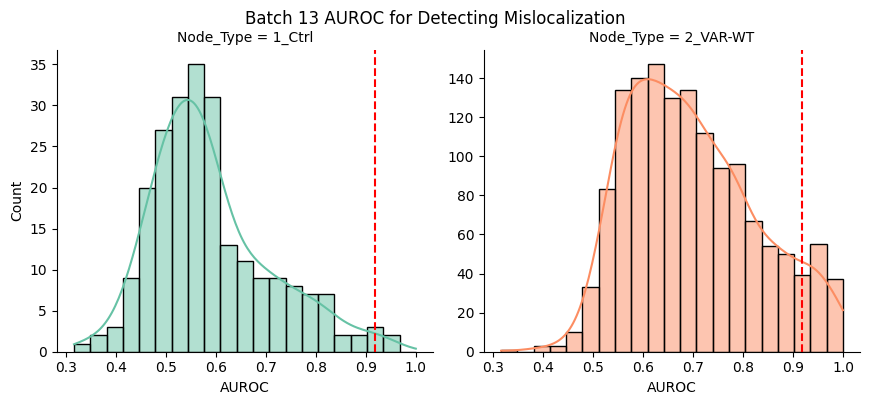

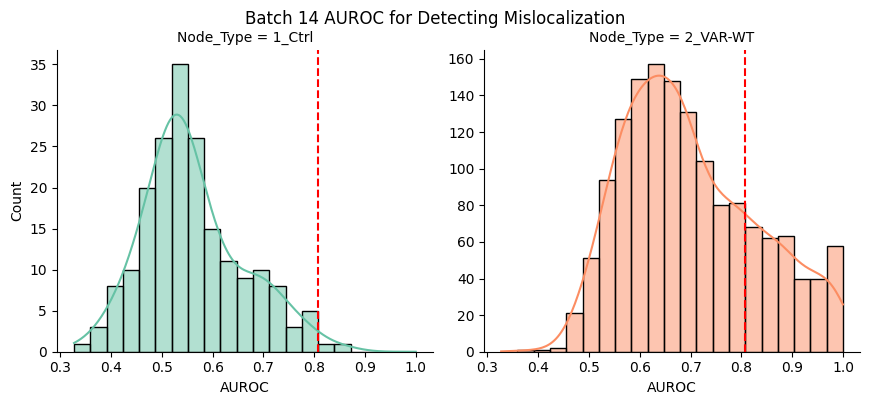

In [11]:
perc_99 = metric_df_dict["B13_met_thres"].filter(pl.col("Classifier_type") == "localization").select("AUROC_thresh").mean().to_numpy()[0][0]
print(perc_99)

# Plot with vertical lines
g = sns.displot(
    data=metric_df_dict["B13_met_thres"].filter((pl.col("Classifier_type") == "localization")&(pl.col("Training_imbalance")<TRN_IMBAL_THRES)), x="AUROC", col="Node_Type", kde=True,
    facet_kws={'sharey': False, 'col_order': sorted(metrics_df['Node_Type'].unique())},
    hue="Node_Type", palette="Set2", hue_order=sorted(metrics_df['Node_Type'].unique()),
    legend=False, height=4, aspect=1.1
)
## Add vertical lines and labels
for ax, node_type in zip(g.axes.flat, sorted(metrics_df['Node_Type'].unique())):
    ax.axvline(perc_99, color='red', linestyle='--')
    # ax.text(perc_99, ax.get_ylim()[1], '99th perc', color='red', ha='center')
# plt.show()

g.fig.suptitle("Batch 13 AUROC for Detecting Mislocalization", fontsize=12, y=1.)
g.fig.subplots_adjust(top=0.9)

perc_99 = metric_df_dict["B14_met_thres"].filter(pl.col("Classifier_type") == "localization").select("AUROC_thresh").mean().to_numpy()[0][0]
print(perc_99)

# Plot with vertical lines
g = sns.displot(
    data=metric_df_dict["B14_met_thres"].filter((pl.col("Classifier_type") == "localization")&(pl.col("Training_imbalance")<TRN_IMBAL_THRES)), x="AUROC", col="Node_Type", kde=True,
    facet_kws={'sharey': False, 'col_order': sorted(metrics_df['Node_Type'].unique())},
    hue="Node_Type", palette="Set2", hue_order=sorted(metrics_df['Node_Type'].unique()),
    legend=False, height=4, aspect=1.1
)
## Add vertical lines and labels
for ax, node_type in zip(g.axes.flat, sorted(metrics_df['Node_Type'].unique())):
    ax.axvline(perc_99, color='red', linestyle='--')
    # ax.text(perc_99, ax.get_ylim()[1], '99th perc', color='red', ha='center')

g.fig.suptitle("Batch 14 AUROC for Detecting Mislocalization", fontsize=12, y=1.)
g.fig.subplots_adjust(top=0.9)

0.9306606944123058
0.9672937981362273


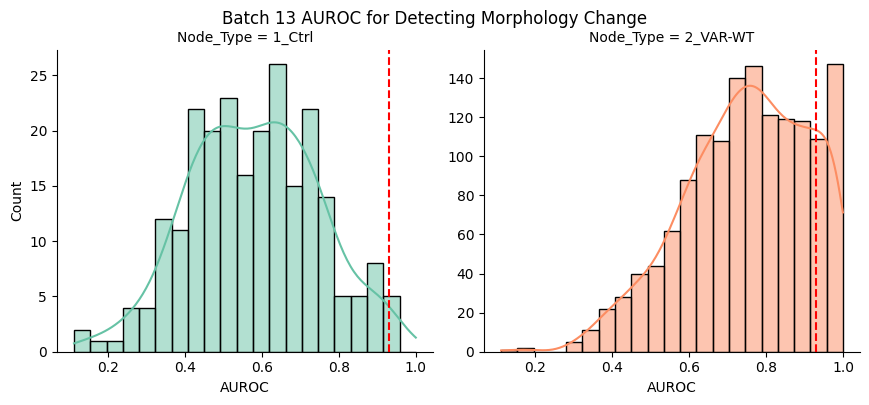

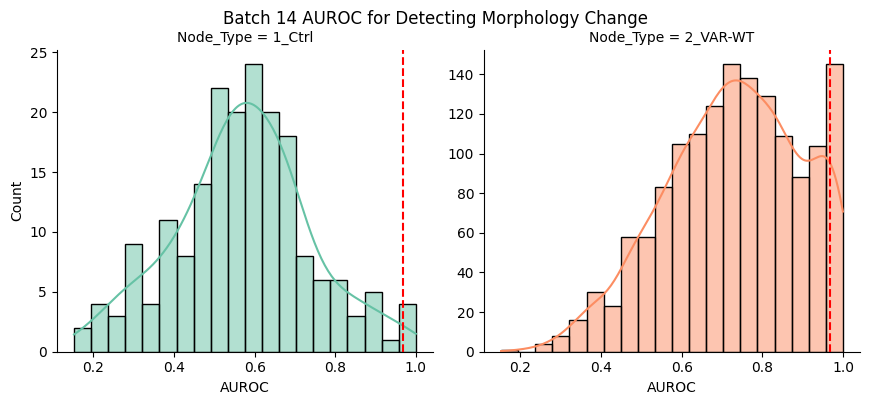

In [13]:
perc_99 = metric_df_dict["B13_met_thres"].filter(pl.col("Classifier_type")=="morphology").select("AUROC_thresh").mean().to_numpy()[0][0]
print(perc_99)

# Plot with vertical lines
g = sns.displot(
    data=metric_df_dict["B13_met_thres"].filter((pl.col("Classifier_type")=="morphology")&(pl.col("Training_imbalance")<TRN_IMBAL_THRES)), x="AUROC", col="Node_Type", kde=True,
    facet_kws={'sharey': False, 'col_order': sorted(metrics_df['Node_Type'].unique())},
    hue="Node_Type", palette="Set2", hue_order=sorted(metrics_df['Node_Type'].unique()),
    legend=False, height=4, aspect=1.1
)
## Add vertical lines and labels
for ax, node_type in zip(g.axes.flat, sorted(metrics_df['Node_Type'].unique())):
    ax.axvline(perc_99, color='red', linestyle='--')
    # ax.text(perc_99, ax.get_ylim()[1], '99th perc', color='red', ha='center')
# plt.show()

g.fig.suptitle("Batch 13 AUROC for Detecting Morphology Change", fontsize=12, y=1.)
g.fig.subplots_adjust(top=0.9)

perc_99 = metric_df_dict["B14_met_thres"].filter(pl.col("Classifier_type")=="morphology").select("AUROC_thresh").mean().to_numpy()[0][0]
print(perc_99)

# Plot with vertical lines
g = sns.displot(
    data=metric_df_dict["B14_met_thres"].filter((pl.col("Classifier_type")=="morphology")&(pl.col("Training_imbalance")<TRN_IMBAL_THRES)), x="AUROC", col="Node_Type", kde=True,
    facet_kws={'sharey': False, 'col_order': sorted(metrics_df['Node_Type'].unique())},
    hue="Node_Type", palette="Set2", hue_order=sorted(metrics_df['Node_Type'].unique()),
    legend=False, height=4, aspect=1.1
)
## Add vertical lines and labels
for ax, node_type in zip(g.axes.flat, sorted(metrics_df['Node_Type'].unique())):
    ax.axvline(perc_99, color='red', linestyle='--')
    # ax.text(perc_99, ax.get_ylim()[1], '99th perc', color='red', ha='center')

g.fig.suptitle("Batch 14 AUROC for Detecting Morphology Change", fontsize=12, y=1.)
g.fig.subplots_adjust(top=0.9)

In [16]:
metrics_files = [
    "../../../8.2_updated_snakemake_pipeline/outputs/classification_analyses/2025_01_27_Batch_13/profiles_tcdropped_filtered_var_mad_outlier_featselect_filtcells/metrics_summary.csv",
    "../../../8.2_updated_snakemake_pipeline/outputs/classification_analyses/2025_01_28_Batch_14/profiles_tcdropped_filtered_var_mad_outlier_featselect_filtcells/metrics_summary.csv"
]

metric_sum_df_dict = {}

for metric_file in metrics_files:
    metric_sum_df = pl.read_csv(metric_file)

    # Assuming you have a Polars DataFrame named df and you want to rank the values in the 'column_name' column
    metric_sum_df = metric_sum_df.with_columns(
        pl.col('AUROC_mean').rank('dense').alias('AUROC_rank')
    )

    print(metric_sum_df.filter((pl.col("Classifier_type") == "localization")&(pl.col("AUROC_mean") >= pl.col("AUROC_thresh"))))
    print(metric_sum_df.filter((pl.col("Classifier_type") == "morphology")&(pl.col("AUROC_mean") >= pl.col("AUROC_thresh"))))

    metric_sum_df_dict[metric_file.split("/")[-3]] = metric_sum_df

shape: (29, 12)
┌────────┬────────┬────────┬───────┬───────┬───────┬───────┬───────┬───────┬───────┬───────┬───────┐
│ Classi ┆ allele ┆ Allele ┆ Batch ┆ AUROC ┆ AUROC ┆ train ┆ tests ┆ train ┆ tests ┆ Train ┆ AUROC │
│ fier_t ┆ _0     ┆ _set   ┆ ---   ┆ _thre ┆ _mean ┆ size_ ┆ ize_0 ┆ size_ ┆ ize_1 ┆ ing_i ┆ _rank │
│ ype    ┆ ---    ┆ ---    ┆ str   ┆ sh    ┆ ---   ┆ 0_mea ┆ _mean ┆ 1_mea ┆ _mean ┆ mbala ┆ ---   │
│ ---    ┆ str    ┆ str    ┆       ┆ ---   ┆ f64   ┆ n     ┆ ---   ┆ n     ┆ ---   ┆ nce_m ┆ u32   │
│ str    ┆        ┆        ┆       ┆ f64   ┆       ┆ ---   ┆ f64   ┆ ---   ┆ f64   ┆ ean   ┆       │
│        ┆        ┆        ┆       ┆       ┆       ┆ f64   ┆       ┆ f64   ┆       ┆ ---   ┆       │
│        ┆        ┆        ┆       ┆       ┆       ┆       ┆       ┆       ┆       ┆ f64   ┆       │
╞════════╪════════╪════════╪═══════╪═══════╪═══════╪═══════╪═══════╪═══════╪═══════╪═══════╪═══════╡
│ locali ┆ ZC4H2_ ┆ A7A8P2 ┆ B13   ┆ 0.918 ┆ 0.943 ┆ 819.7 ┆ 273.2 ┆ 1137. 

## 3. Correlation between biological replicates

Spearman's correlation: 0.5432032959100955
Spearman's correlation: 0.8598303066858605


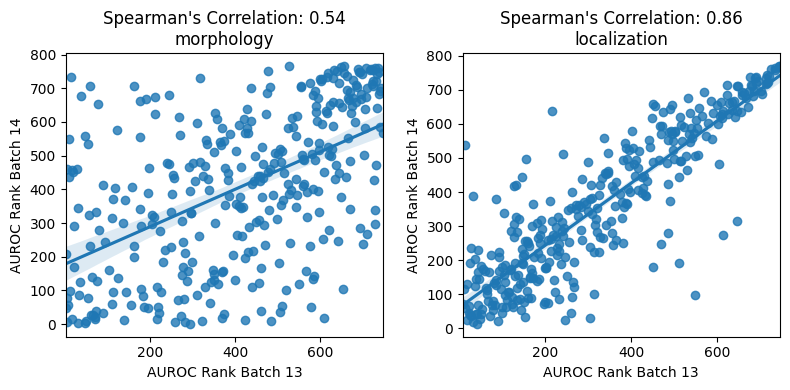

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import spearmanr

fig, axes = plt.subplots(1, 2, figsize=(8,4))
classifier_type = "morphology"
# Select the columns "allele_0" and "AUROC_rank" from both dataframes
set1_ranks = metric_sum_df_dict["2025_01_27_Batch_13"].filter((pl.col("Classifier_type") == classifier_type)).select(["allele_0", "AUROC_rank"])
set2_ranks = metric_sum_df_dict["2025_01_28_Batch_14"].filter((pl.col("Classifier_type") == classifier_type)).select(["allele_0", "AUROC_rank"])
# Join the dataframes on the "allele_0" column
joined_ranks = set1_ranks.join(set2_ranks, on="allele_0", how="inner", suffix="_batch14")
# Calculate the Spearman's correlation between the ranks
spearman_corr, _ = spearmanr(joined_ranks["AUROC_rank"], joined_ranks["AUROC_rank_batch14"])
print(f"Spearman's correlation: {spearman_corr}")

# Plot the correlation using a regression plot
sns.regplot(x="AUROC_rank", y="AUROC_rank_batch14", data=joined_ranks.to_pandas(), ax=axes[0])
axes[0].set_title(f"Spearman's Correlation: {spearman_corr:.2f}\n{classifier_type}")
axes[0].set_xlabel("AUROC Rank Batch 13")
axes[0].set_ylabel("AUROC Rank Batch 14")

classifier_type = "localization"
# Select the columns "allele_0" and "AUROC_rank" from both dataframes
set1_ranks = metric_sum_df_dict["2025_01_27_Batch_13"].filter((pl.col("Classifier_type") == classifier_type)).select(["allele_0", "AUROC_rank"])
set2_ranks = metric_sum_df_dict["2025_01_28_Batch_14"].filter((pl.col("Classifier_type") == classifier_type)).select(["allele_0", "AUROC_rank"])
# Join the dataframes on the "allele_0" column
joined_ranks = set1_ranks.join(set2_ranks, on="allele_0", how="inner", suffix="_batch14")
# Calculate the Spearman's correlation between the ranks
spearman_corr, _ = spearmanr(joined_ranks["AUROC_rank"], joined_ranks["AUROC_rank_batch14"])
print(f"Spearman's correlation: {spearman_corr}")

# Plot the correlation using a regression plot
sns.regplot(x="AUROC_rank", y="AUROC_rank_batch14", data=joined_ranks.to_pandas(), ax=axes[1])
axes[1].set_title(f"Spearman's Correlation: {spearman_corr:.2f}\n{classifier_type}")
axes[1].set_xlabel("AUROC Rank Batch 13")
axes[1].set_ylabel("AUROC Rank Batch 14")

plt.tight_layout()
plt.subplots_adjust(wspace=.25)

In [18]:
set1 = metric_sum_df_dict["2025_01_27_Batch_13"].filter((pl.col("Classifier_type") == "localization")&(pl.col("AUROC_mean") >= pl.col("AUROC_thresh"))).select(pl.col("allele_0"))
set2 = metric_sum_df_dict["2025_01_28_Batch_14"].filter((pl.col("Classifier_type") == "localization")&(pl.col("AUROC_mean") >= pl.col("AUROC_thresh"))).select(pl.col("allele_0"))

## 4. Calling hits

In [19]:
metrics_wtvar = pl.concat(
    [
        pl.read_csv("../../../8.2_updated_snakemake_pipeline/outputs/classification_analyses/2025_01_27_Batch_13/profiles_tcdropped_filtered_var_mad_outlier_featselect_filtcells/metrics_summary.csv").with_columns(
            pl.lit("B13").alias("Batch")),
        pl.read_csv("../../../8.2_updated_snakemake_pipeline/outputs/classification_analyses/2025_01_28_Batch_14/profiles_tcdropped_filtered_var_mad_outlier_featselect_filtcells/metrics_summary.csv").with_columns(
            pl.lit("B14").alias("Batch"))
    ]
)
metrics_wtvar

Classifier_type,allele_0,Allele_set,Batch,AUROC_thresh,AUROC_mean,trainsize_0_mean,testsize_0_mean,trainsize_1_mean,testsize_1_mean,Training_imbalance_mean
str,str,str,str,f64,f64,f64,f64,f64,f64,f64
"""morphology""","""CCM2_Arg346Cys""","""A7A8P2_""","""B13""",0.930661,0.795169,1539.0,513.0,3616.5,1205.5,2.353902
"""morphology""","""CCM2_Ser248Gly""","""A7A8P2_""","""B13""",0.930661,0.739677,1678.5,559.5,3616.5,1205.5,2.160709
"""localization""","""RET_Gly321Arg""","""A7A8P2_""","""B13""",0.918113,0.588794,1054.5,351.5,999.0,333.0,1.111349
"""morphology""","""BRCA1_Cys64Tyr""","""A7A8P1_""","""B13""",0.930661,0.876778,1092.0,364.0,1151.25,383.75,1.139109
"""localization""","""CCM2_Pro55Ala""","""A7A8P2_""","""B13""",0.918113,0.74854,1356.333333,385.666667,3615.0,1207.0,2.665478
"""localization""","""CCM2_Ile92Thr""","""A7A8P2_""","""B13""",0.918113,0.74183,1594.5,531.5,3616.5,1205.5,2.280092
"""localization""","""BAP1_Pro12Thr""","""A7A8P1_""","""B13""",0.918113,0.590063,1520.25,506.75,1183.5,394.5,1.295413
"""morphology""","""SDHD_His50Asp""","""A7A8P2_""","""B13""",0.930661,0.934088,1373.25,457.75,1734.0,578.0,1.265919
"""morphology""","""SHOC2_Ser2Gly""","""A7A8P1_""","""B13""",0.930661,0.881231,619.5,206.5,1102.5,367.5,1.829338


In [22]:
# split into morphology and localization, and count the proportion of classifiers that surpass the 0.99 NULL F1 score
morph_wtvar = metrics_wtvar.filter(pl.col("Classifier_type") == "morphology")
local_wtvar = metrics_wtvar.filter(pl.col("Classifier_type") == "localization")
print(local_wtvar.shape)
print(morph_wtvar.shape)

(759, 11)
(759, 11)


In [26]:
# Alleles must be mislocalized in both batches
local_wtvar = local_wtvar.with_columns(
    pl.when(pl.col("AUROC_mean") > pl.col("AUROC_thresh"))
    .then(1)
    .otherwise(0)
    .alias("mislocalized")
).unique()

misloc_binary = (
    local_wtvar.pivot(
        index=["allele_0", "Allele_set"],
        on="Batch",
        values="mislocalized",
    )
    .with_columns(
        ((pl.col("B13") == 1) & (pl.col("B14") == 1)).alias(
            "mislocalized_both_batches"
        )
    )
    .rename({"B13": "mislocalized_batch13", "B14": "mislocalized_batch14"})
)

misloc_auroc = local_wtvar.pivot(
    index=["allele_0"],
    on="Batch",
    values="AUROC_mean",
).rename({"B13": "auroc_batch13", "B14": "auroc_batch14"})

# misloc_auroc = misloc_auroc.with_columns(
#     ((pl.col("auroc_batch13") + pl.col("auroc_batch14")) / 2).alias("mean_auroc")
# )

# misloc_summary = misloc_binary.join(misloc_auroc, on="allele_0")
# # display(misloc_summary)
# misloc_summary.filter(pl.col("mislocalized_both_batches"))

# misloc_summary.write_csv(f"{metrics_dir}/misloc_summary_auroc.csv")

ComputeError: found multiple elements in the same group, please specify an aggregation function

In [27]:
local_wtvar

Classifier_type,allele_0,Allele_set,Batch,AUROC_thresh,AUROC_mean,trainsize_0_mean,testsize_0_mean,trainsize_1_mean,testsize_1_mean,Training_imbalance_mean,mislocalized
str,str,str,str,f64,f64,f64,f64,f64,f64,f64,i32
"""localization""","""CCM2_Ala98Pro""","""A7A8P2_""","""B14""",0.806489,0.61582,1264.333333,363.666667,3264.666667,1122.333333,2.593649,0
"""localization""","""BRAF_Glu501Lys""","""A7A8P1_""","""B13""",0.918113,0.717389,1235.25,411.75,1319.25,439.75,1.066331,0
"""localization""","""BAP1_Asn290Ser""","""A7A8P1_""","""B14""",0.806489,0.546238,867.75,289.25,1064.25,354.75,1.231158,0
"""localization""","""RAD51D_Gly289Ser""","""A7A8P2_""","""B13""",0.918113,0.77015,2208.75,736.25,1200.75,400.25,1.842594,0
"""localization""","""CCM2_Thr44Ser""","""A7A8P2_""","""B13""",0.918113,0.640791,1410.75,470.25,3616.5,1205.5,2.564175,0
"""localization""","""BRCA1_Glu143Lys""","""A7A8P1_""","""B13""",0.918113,0.605949,1399.5,466.5,1151.25,383.75,1.246153,0
"""localization""","""ZC4H2_Ile7Val""","""A7A8P2_""","""B14""",0.806489,0.763894,864.0,288.0,948.0,316.0,1.110477,0
"""localization""","""CCM2_Arg389Trp""","""A7A8P2_""","""B14""",0.806489,0.725903,1624.5,541.5,3290.25,1096.75,2.04404,0
"""localization""","""F9_His303Tyr""","""A7A8P1_""","""B13""",0.918113,0.505263,573.75,191.25,730.5,243.5,1.277504,0


In [ ]:
misloc_summary.filter(((pl.col("mislocalized_batch13")==1)|(pl.col("mislocalized_batch14")==1))&(pl.col("allele_0").str.contains("CCM2")))["allele_0","mislocalized_both_batches","auroc_batch13","auroc_batch14"]

allele_0,mislocalized_both_batches,auroc_batch13,auroc_batch14
str,bool,f64,f64
"""CCM2_Ile432Phe""",false,0.787646,0.822512
"""CCM2_Val190Met""",false,0.787355,0.821167
"""CCM2_Asp376His""",false,0.851446,0.83811
"""CCM2_Arg412Trp""",false,0.757871,0.818862
"""CCM2_Ile432Thr""",true,0.986747,0.985792
"""CCM2_Ser251Tyr""",false,0.769184,0.866477
"""CCM2_Ile372Leu""",null,null,0.876099
"""CCM2_Ser183Leu""",null,null,0.835743
"""CCM2_Gly379Ser""",null,null,0.831455


In [ ]:
# Alleles must be morph_changed in both batches
morph_wtvar = morph_wtvar.with_columns(
    pl.when(pl.col("AUROC_mean") > pl.col("AUROC_thresh"))
    .then(1)
    .otherwise(0)
    .alias("morph_changed")
).unique()

misloc_binary = (
    morph_wtvar.pivot(
        index=["allele_0", "Allele_set"],
        on="Batch",
        values="morph_changed",
    )
    .with_columns(
        ((pl.col("B13") == 1) & (pl.col("B14") == 1)).alias(
            "morph_changed_both_batches"
        )
    )
    .rename({"B13": "morph_changed_batch13", "B14": "morph_changed_batch14"})
)

morph_auroc = morph_wtvar.pivot(
    index=["allele_0"],
    on="Batch",
    values="AUROC_mean",
).rename({"B13": "auroc_batch13", "B14": "auroc_batch14"})

morph_auroc = morph_auroc.with_columns(
    ((pl.col("auroc_batch13") + pl.col("auroc_batch14")) / 2).alias("mean_auroc")
)

morph_summary = misloc_binary.join(morph_auroc, on="allele_0")
display(morph_summary)
morph_summary.filter(pl.col("morph_changed_both_batches"))
# misloc_summary.write_csv(f"{metrics_dir}/misloc_summary_auroc.csv")

allele_0,Allele_set,morph_changed_batch14,morph_changed_batch13,morph_changed_both_batches,auroc_batch14,auroc_batch13,mean_auroc
str,str,i32,i32,bool,f64,f64,f64
"""F9_Cys407Arg""",null,0,0,false,0.576203,0.835801,0.706002
"""CCM2_Leu212Val""",null,0,0,false,0.685998,0.73916,0.712579
"""CCM2_Ile130Val""",null,0,null,false,0.689278,null,null
"""F9_Lys39Arg""",null,0,0,false,0.551992,0.528761,0.540376
"""ZC4H2_Leu66His""",null,0,0,false,0.949121,0.821291,0.885206
"""RAD51D_Val28Leu""",null,0,0,false,0.942046,0.851858,0.896952
"""SOS2_Val869Ile""",null,0,0,false,0.767156,0.6474,0.707278
"""CCM2_Glu223Val""",null,0,0,false,0.785592,0.697903,0.741747
"""CCM2_Ile432Thr""",null,0,0,false,0.528906,0.756508,0.642707


allele_0,Allele_set,morph_changed_batch14,morph_changed_batch13,morph_changed_both_batches,auroc_batch14,auroc_batch13,mean_auroc
str,str,i32,i32,bool,f64,f64,f64
"""BRCA1_Asn132Lys""",null,1,1,true,0.975409,0.987992,0.981701
"""BRCA1_His239Arg""",null,1,1,true,0.97262,0.983294,0.977957
"""BRCA1_His299Tyr""",null,1,1,true,0.983039,0.972684,0.977862
"""BRAF_Val471Phe""",null,1,1,true,0.979039,0.961337,0.970188
"""BRCA1_Pro510Ser""",null,1,1,true,0.983464,0.96298,0.973222
"""BRCA1_Met548Ile""",null,1,1,true,0.987541,0.976542,0.982042
"""BRCA1_Phe558Ser""",null,1,1,true,0.985567,0.949107,0.967337
"""BRCA1_Ser186Tyr""",null,1,1,true,0.989642,0.989562,0.989602


In [66]:
morph_summary.filter(((pl.col("morph_changed_batch14")==1)|(pl.col("morph_changed_batch13")==1))&(pl.col("allele_0").str.contains("CCM2")))

allele_0,Allele_set,morph_changed_batch14,morph_changed_batch13,morph_changed_both_batches,auroc_batch14,auroc_batch13,mean_auroc
str,str,i32,i32,bool,f64,f64,f64
"""CCM2_Pro240Leu""",null,null,1,null,null,0.945549,null
"""CCM2_Tyr261Asp""",null,0,1,false,0.8641,0.98256,0.92333
"""CCM2_Val190Met""",null,0,1,false,0.573872,0.941028,0.75745
"""CCM2_Ser164Phe""",null,0,1,false,0.734119,0.97909,0.856604
"""CCM2_Met439Ile""",null,null,1,null,null,0.950355,null


In [67]:
# misloc_summary.filter(pl.col("mislocalized_both_batches"))

In [65]:
misloc_summary.filter(((pl.col("mislocalized_batch14")==1)|(pl.col("mislocalized_batch13")==1))&(pl.col("allele_0").str.contains("CCM2")))

allele_0,Allele_set,mislocalized_batch14,mislocalized_batch13,mislocalized_both_batches,auroc_batch14,auroc_batch13,mean_auroc
str,str,i32,i32,bool,f64,f64,f64
"""CCM2_Ile432Thr""",null,1,1,true,0.985792,0.986747,0.986269
"""CCM2_Gly379Ser""",null,1,null,null,0.831455,null,null
"""CCM2_Asp376His""",null,1,0,false,0.83811,0.851446,0.844778
"""CCM2_Asp301Gly""",null,1,null,null,0.866984,null,null
"""CCM2_Ser251Tyr""",null,1,0,false,0.866477,0.769184,0.81783
"""CCM2_Arg412Trp""",null,1,0,false,0.818862,0.757871,0.788366
"""CCM2_Ile372Leu""",null,1,null,null,0.876099,null,null
"""CCM2_Ile432Phe""",null,1,0,false,0.822512,0.787646,0.805079
"""CCM2_Ser183Leu""",null,1,null,null,0.835743,null,null


In [ ]:
misloc_summary.filter(pl.col("mislocalized_both_batches"))

In [ ]:
# # Alleles must be mislocalized in both batches
# local_wtvar = wtvar_summary.with_columns(
#     pl.when(pl.col("AUROC_mean") > pl.col("AUROC_thresh"))
#     .then(1)
#     .otherwise(0)
#     .alias("mislocalized")
# ).unique()

# misloc_binary = (
#     wtvar_summary.pivot(
#         index=["allele_0", "Allele_set"],
#         on="Batch",
#         values="mislocalized",
#     )
#     .with_columns(
#         ((pl.col("batch13") == 1) & (pl.col("batch14") == 1)).alias(
#             "mislocalized_both_batches"
#         )
#     )
#     .rename({"batch13": "mislocalized_batch13", "batch14": "mislocalized_batch14"})
# )
# auroc_zscore = wtvar_summary.pivot(
#     index=["allele_0","Allele_set","Classifier_type"],
#     on="Batch",
#     values="AUROC_zscore_mean",
# ).rename({"B7": "auroc_zscore_b7", "B8": "auroc_zscore_b8"})

# # misloc_summary = misloc_binary.join(misloc_auroc, on="allele_0")
# display(auroc_zscore)

# auroc_zscore.write_csv("/home/shenrunx/igvf/varchamp/2025_laval_submitted/2_individual_assay_results/imaging/3_outputs/sm_xgb_classifier_metrics/auroc_zscore_b7-8.csv")